In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# Pitch Grading: Modeling Conventional Wisdom in Assessing Fastballs and Sliders#

What constitutes a good pitch? If you were asked this question with no other information, you would likely answer the same way, regardless of whether you were a baseball expert or a casual fan: a good pitch is one that results in a strike or an out. In the absence of results, though, if a group of people were shown a series of pitches and asked to judge them, we would likely see some consensus in what was and was not considered a "good" pitch. Further, it turns out that there are professional hitters and pitchers in Major League Baseball: sometimes, great pitches yield negative outcomes and other times, bad pitches get outs. 

In this study, I will explore some of the biases and generally accepted ideas of the make up of a good pitch. In doing so, I will examine a Trackman data set consisting of a full season of fastballs and sliders thrown by left-handed pitchers to left-handed hitters. I first want to test generally accepted ideas, building a basic model to rank pitch quality, fully independent of the outcomes of those pitches. Then, I will use the model to grade all of the pitches in the dataset and test the results against the pitch outcomes to see how the model performs. "But...why?" you ask. "What's the point?" The idea here would be to examine pitch quality through the lens of conventional wisdom in order to see whether we can validate what we think we know from experience. 

## Methodology##

Grading the quality of pitches based on provided Trackman data, completely blind to the pitch outcomes, will require some serious assumptions. What defines a pitch as good? A strike outcome would seem to be a safe indicator. However, as defined, this exercise requires an assessment of pitch quality independent of results. The data set provides two fields that contain results: call and result. I will assume that both fields are considered results and build a model without considering either.

**Assumption: call and result both provide pitch results, and the model should be built independent of both.**

Assessing quality without accounting for outcomes removes supervised machine learning models from contention. This leaves two possibilities: build an unsupervised machine learning model and look for clustering, guessing at which clusters represent "good" pitches, or create a linear model, guessing at assigning weights. I am choosing a version of the latter. Machine learning fits a model to the data, which would be better for finding how well an average pitch performs. In this case, we want the outliers: what makes the best pitch. I will attempt to define the perfect theoretical pitch and measure deviations from it.

It might be feasible to apply an unsupervised method, but I think a more direct approach would be to treat each input factor as an independent normal distribution and determine factor quality by its standard deviation from the mean. I will bucket the inputs based on those standard deviations. This will produce a data-driven methodology that I can report in a way that matches traditional scouting scores, which will, in turn, make the scoring easier to digest. 

  
### Input Factors###

What factors contribute? Conventional wisdom says location, velocity, and movement (many sources). More modern research says spin rate is another major factor (also many sources, but I am partial to Jonah Pemstein's writing on this).

I will assess location, velocity, movement, and spin rate in my calculations. Each presents unique challenges, and combining them will require a large assumption: that each factor should have equal weight. Different analysts cite different "most important" factors in pitch success: some say location is the key, while others claim velocity or late movement drive success. Without fitting a model to results, I cannot assume that any one factor is more important than another, so I will weight them equally in my model.



**Assumption: Location, velocity, movement, and spin rate should all be weighted equally in the pitch grading model.**

Looking at the factors in more detail:

### Velocity###

Velocity is the easiest factor to assess. Everything I have observed and read is consistent in assuming that higher velocity is better, for both fastballs and sliders. I will proceed with this assumption.

**Velocity Assumption: Higher velocity is preferable.**

### Spin Rate###

Spin rate has an effect on both movement and velocity. However, the spin rate effect is a bit more subtle - it increases movement and decreases velocity during the flight path of the ball. This makes it a potentially good proxy variable for deception. Research has shown that higher spin rate correlates well with positive pitch outcomes for fastballs and sliders (Pemstein). The same research shows a correlation between very low spin rate and positive pitch outcomes. I would assume this is mainly due to deception: any change in the expected behavior of a pitch would logically throw off a batter's timing. However, swing percentage is also very low for low-spin pitches. When a batter swings, they do not seem to make good contact, but swings are much rarer. Without further study, I cannot assess low-spin pitches well, and have to assume that the contact and swing percentage effects cancel out to some degree. This leads to my main assumption for spin rate: higher spin rate is preferable.

**Spin Rate Assumption: Higher spin rate is preferable.**

### Movement###

The Trackman data provide multiple ways to track movement of a pitch during flight: horizontal and vertical in-flight components, along with the horizontal and vertical angles at which a pitch enters the strike zone. The in-flight movement components should provide an adequate overall measure of movement. I will disregard the horizontal and vertical angles; these should be sufficiently captured in the overall movement measures.

I have read about the importance of "late break", but as David Kagan pointed out in a 2017 article, in physics, all break is late break. I will use basic geometry to calculate a single movement component and proceed with the assumption that more movement is preferable. The data set defines movement as the deviation from the straight-line trajectory of the pitch. This means that a pitch that ends up five feet outside of the strike zone does not necessarily get points for movement.

**Movement Assumption: More overall movement is preferable.**

### Location###

Location is the trickiest variable to measure objectively in an aggregated data set. What defines a pitch location as good varies by the hitter, and not just in terms of the strike zone. In building this model, I will first focus on what is definitively not a good location: the middle of the strike zone. Beyond that, I can say with some certainty that substantially outside the strike zone is also not good.

That leaves the edges of the strike zone. I will define the edges with a standard, generic strike zone (1 foot horizontally on either side of the center of the plate and stretching vertically from 1.5 feet from the ground to 3.5 feet). I will break this strike zone into a 4x4 grid of six-inch squares. The four squares in the center will represent the middle of the zone. The rest will be the edges. I will consider everything on the left and right edges to be good location. The top and bottom edges in the center of the zone are still good, but less good. This is not perfect, as not all edges are created equal; down and in can be an extremely dangerous location, depending on the hitter. Since the data consider all left-handed hitters in the aggregate, treating edges equally is probably my best starting point. There is also some gray area with the edges of the strike zone, particularly with sliders: often, placing a slider just outside the strike zone is the perfect location.

**Location Assumptions: The strike zone is a 2-ft square centered on home plate and 2.5 feet above the ground. Outside the zone is poor location. The 1-ft square in the center of the zone is poor location. The left and right edges are the best location and equally good, while the top and bottom edges in the center of the plate are less good.**

The tasks to accomplish in order to grade fastballs and sliders:

- Explore and clean the data.
- Isolate fastball and slider data into separate data sets.
- Define methodology for assessing pitch quality.
- Calculate the inputs and outputs for quality assessment.
- Assign grades to pitches.
- Validate and test model.

Step 1: explore the data.

In [3]:
allpitches = pd.read_csv('all_fb_sl.csv')
# allpitches = pd.read_csv('all_pitches_trackman.csv')
allpitches.head()

,pitch_id,p_type,call,result,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle
0,23975,FB,StrikeSwinging,Undefined,92.614932,2062.363369,158.189582,6.657738,-1.934755,5.886618,17.054645,-6.835823,2.647593,0.109630,-5.817452,1.529552
1,10381,FB,BallCalled,Undefined,93.505779,2074.372290,145.191262,6.452201,-0.676566,5.902529,5.928455,-4.140085,0.884391,0.282608,-8.449087,0.629116
2,15426,FB,BallCalled,Undefined,93.434940,2167.853571,148.231700,5.915799,-1.583470,6.140743,16.447586,-10.201667,0.864483,1.052220,-6.918216,1.850025
3,20995,SL,InPlay,Out,78.736644,2386.768650,259.898029,6.256930,-1.813793,5.293332,2.796726,15.913225,2.390938,1.280305,-8.259049,4.839435
4,34326,SL,FoulBall,Undefined,78.430132,2435.990635,250.780912,6.336123,-1.685950,5.731613,4.291393,12.418729,3.081289,-0.105870,-7.482266,2.913148


First, I want to examine the summary statistics and compare the data with the given definitions to see if they make sense. 

Given Definitions:
- pitch_id: distinct numbering for each pitch in the data set
- p_type: fastball or slider
- call: pitch call event
- result: outcome of play
- speed: Release speed of pitch leaving the pitcher's hand, in MPH
- spin: The spin rate of the ball leaving the pitcher's hand in RPM
- height: The height above home plate of the release point (ft)
- side: The distance from the center of the rubber of the release point (ft)
- extension: The distance in front of the pitching rubber of the release point (ft)
- vert_break: Vertical distance in inches between where the pitch crosses the front of home plate and where it would have crossed had it traveled in a perfectly straight line from release, where negative is moving toward the ground
- horz_break: Horizontal distance in inches between where the pitch crosses the front of home plate and where it would have crossed had it traveled in a perfectly straight line from release, where negative is moving in toward a left-handed hitter
- plate_height: The height above home plate at which the pitch crosses the plate (ft), where negative is more toward to a left-handed hitter
- vert_angle: The vertical angle, in degrees, at which the ball enters the zone as the pitch crosses the front of home plate. A negative number means it is sloping downward, while a positive number means it is sloping upward
- horz_angle: The horozontal angle, in degrees, at which a pitched ball crosses the front of home plate. A negative number means that the ball is moving away from a right-handed batter as it enters the zone, and a positive number means that the ball is moving in on a right-handed batter as it enters the zone

In [5]:
allpitches.describe()

,pitch_id,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle
count,98559.000000,46301.000000,45725.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000
mean,10903.541473,89.133032,2238.073296,173.310543,5.853852,-2.218697,5.944533,9.314542,-5.328525,2.251383,0.230245,-6.401361,2.112293
std,14769.373419,5.033738,218.024527,59.020479,0.565184,0.822552,0.505239,7.151143,9.055900,0.886434,0.835276,1.596462,1.655482
min,-1.000000,69.830884,461.149269,0.054012,2.271348,-5.333208,3.623688,-48.667125,-26.395298,-2.150201,-3.826428,-14.244603,-3.335348
25%,-1.000000,86.016887,2096.729380,133.827539,5.619753,-2.735423,5.622495,3.740005,-12.515609,1.680182,-0.322116,-7.425598,0.983569
50%,-1.000000,90.426716,2233.631403,154.606606,5.919967,-2.189571,5.970150,10.728950,-7.280526,2.257427,0.243548,-6.205223,2.042509
75%,21721.500000,92.707419,2370.443116,203.870733,6.194532,-1.685624,6.296149,15.295612,1.889626,2.822474,0.799435,-5.256737,3.178489
max,46361.000000,103.288490,3726.136503,359.883393,8.513335,1.031696,7.744261,64.625719,51.117875,7.512057,4.545302,4.243111,9.981524


It looks as though more than half of the data points have a pitch ID of "-1". Those will require some examination.

In [7]:
allpitches[allpitches['pitch_id']==-1].head()

,pitch_id,p_type,call,result,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle
46362,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46363,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46364,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46365,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46366,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Null Data###
I suppressed the output for ease of reading, but it appears as though all of the "-1" data are null rows. It should be safe to remove these from the data set.

In [12]:
allpitches = allpitches[allpitches['pitch_id']>-1]
allpitches.describe()

,pitch_id,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle
count,46362.000000,46301.000000,45725.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000
mean,23180.500000,89.133032,2238.073296,173.310543,5.853852,-2.218697,5.944533,9.314542,-5.328525,2.251383,0.230245,-6.401361,2.112293
std,13383.700927,5.033738,218.024527,59.020479,0.565184,0.822552,0.505239,7.151143,9.055900,0.886434,0.835276,1.596462,1.655482
min,0.000000,69.830884,461.149269,0.054012,2.271348,-5.333208,3.623688,-48.667125,-26.395298,-2.150201,-3.826428,-14.244603,-3.335348
25%,11590.250000,86.016887,2096.729380,133.827539,5.619753,-2.735423,5.622495,3.740005,-12.515609,1.680182,-0.322116,-7.425598,0.983569
50%,23180.500000,90.426716,2233.631403,154.606606,5.919967,-2.189571,5.970150,10.728950,-7.280526,2.257427,0.243548,-6.205223,2.042509
75%,34770.750000,92.707419,2370.443116,203.870733,6.194532,-1.685624,6.296149,15.295612,1.889626,2.822474,0.799435,-5.256737,3.178489
max,46361.000000,103.288490,3726.136503,359.883393,8.513335,1.031696,7.744261,64.625719,51.117875,7.512057,4.545302,4.243111,9.981524


Based on the uneven counts, there may be additional null rows. 

In [16]:
allpitches[pd.isna(allpitches['speed'])].head()

,pitch_id,p_type,call,result,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle
1210,37349,FB,BallCalled,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1440,13640,FB,InPlay,Out,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3133,28133,FB,BallCalled,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4597,31956,FB,FoulBall,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5353,26363,SL,Undefined,Out,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 61 additional rows that contain type, call, and results, but no other information about the pitches. It is safe to remove these as well. 

In [17]:
allpitches = allpitches[pd.notna(allpitches['speed'])]
allpitches.describe()

,pitch_id,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle
count,46301.000000,46301.000000,45725.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000,46301.000000
mean,23177.717760,89.133032,2238.073296,173.310543,5.853852,-2.218697,5.944533,9.314542,-5.328525,2.251383,0.230245,-6.401361,2.112293
std,13387.303887,5.033738,218.024527,59.020479,0.565184,0.822552,0.505239,7.151143,9.055900,0.886434,0.835276,1.596462,1.655482
min,0.000000,69.830884,461.149269,0.054012,2.271348,-5.333208,3.623688,-48.667125,-26.395298,-2.150201,-3.826428,-14.244603,-3.335348
25%,11579.000000,86.016887,2096.729380,133.827539,5.619753,-2.735423,5.622495,3.740005,-12.515609,1.680182,-0.322116,-7.425598,0.983569
50%,23168.000000,90.426716,2233.631403,154.606606,5.919967,-2.189571,5.970150,10.728950,-7.280526,2.257427,0.243548,-6.205223,2.042509
75%,34775.000000,92.707419,2370.443116,203.870733,6.194532,-1.685624,6.296149,15.295612,1.889626,2.822474,0.799435,-5.256737,3.178489
max,46361.000000,103.288490,3726.136503,359.883393,8.513335,1.031696,7.744261,64.625719,51.117875,7.512057,4.545302,4.243111,9.981524


In [27]:
# Count remaining null values by row.
allpitches.isnull().sum()

pitch_id          0
p_type            0
call              0
result            0
speed             0
spin            576
axis              0
height            0
side              0
extension         0
vert_break        0
horz_break        0
plate_height      0
plate_side        0
vert_angle        0
horz_angle        0
dtype: int64

I have now isolated the data set nulls to spin. I will replace these values with the mean for spin rate, but I will wait until I split the data into fastball and slider subsets, as those two pitch types should have very different mean spin rates.

### Observations###

After processing the null values, the resultant data set includes 46,301 records. 

Initial Observations:
- It appears there may be some missing data points in the spin_rate column.
- Spin rate appears to have some outliers. The minimum (461) and maximum (3726) are both beyond what I would expect to see. The spin column also seems to be missing some data - there are 45,725 entries for spin rate, but 46,301 for all other categories.
- Axis ranges from almost zero to almost 360. No definition was provided with the data set, but I would assume this is in degrees, which would fit the data.
- Height is reported in feet. This field also may have some outliers, though the values shown are possible. A very tall pitcher could feasibly have an 8.51-ft release point (though that would likely be a mistake), and a submarine pitcher could have a 2.27-ft release point. Most of this field is a tight spread around the mean.
- Side is reported in feet and mostly makes logical sense. Most of the values are negative, which is logical (assuming negative means closer to a left-handed hitter, as it is for some other definitions here). The minimum value (-5.33 ft) does not make intuitive sense. 
- Extension is reported in feet and the spread of the data is logical.
- vert_break is reported in inches and does not make intuitive sense, per the definition. As defined, negative break is moving toward the ground. Logically, I would expect almost all of this field to be negative, but the opposite is true. The minimum value would represent a drop of over 4 ft, which seems impossible.
- horz_break also has problems. For left-handed pitcher throwing to left-handed hitters, I would expect most pitches to break away from the hitters, but the majority of the data shows pitches breaking toward hitters.
- plate_height is reported in feet. There seem to be problems here as well, as the field has a minimum value of -2.15, which would be over two feet below the ground. This will take further scrutiny.
- plate_loc_side is not given a definition, but from context, I assume this to be the horizontal offset, in feet, at which the pitch crosses the plate, with negative meaning more toward a left-handed hitter. The data range seems reasonable. The minimum value, -3.8 ft, is a bit extreme, but certainly within the realm of the possible.
- vert_angle is the angle at which the pitch crosses the plate (with zero meaning straight and negative toward the ground). This range of values aligns with expectations. There is far more downward drop than rise. 
- horz_angle is the horizontal angle at which the pitch crosses the plate, with negative meaning toward a left-handed batter. These values also align with expectations. In a data set containing left-handed pitchers and hitters, and a large proportion of sliders, I would expect to see more of an angle away from the hitter. 

Before I examine the suspect data, I will convert some of the fields to make sure that I have consistent units throughout analysis. I will convert inches to feet.

In [18]:
# Convert fields measure in inches to feet.
allpitches['vert_break'] = allpitches['vert_break']/12
allpitches['horz_break'] = allpitches['horz_break']/12

### Pitch Location###

I will start the deeper exploratory analysis with the anomaly that was the most distressing: negative height values in pitch location. I will start examining the discrepancies by plotting all pitches.

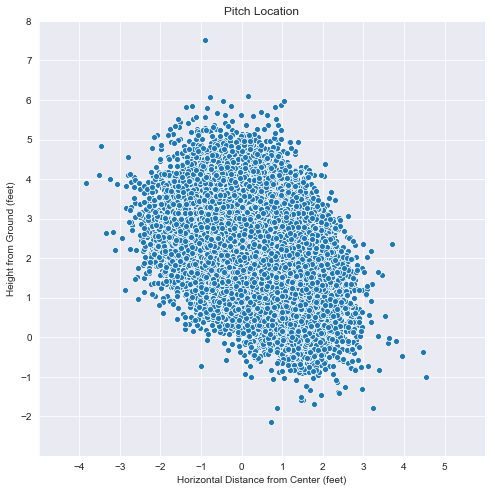

In [19]:
# Set Seaborn style.
sns.set_style('darkgrid')

# Plot all pitches.
plt.subplots(figsize=(8,8))
sns.scatterplot(x=allpitches['plate_side'], y=allpitches['plate_height'])
plt.axis([-5, 6, -3, 8])
plt.xticks(np.arange(-4, 6, step=1))
plt.yticks(np.arange(-2, 9, step=1))
plt.title('Pitch Location')
plt.xlabel('Horizontal Distance from Center (feet)')
plt.ylabel('Height from Ground (feet)')
plt.show()

The horizontal spread of the data is what I would expect to see with so many sliders and all left-handed pitchers. 

There is a major problem here, though: many pitches appear to be crossing the plate below the ground. My guess is this is a flaw in Trackman's reporting. It is possible that Trackman is providing bad height data if a pitch bounces before reaching the plate (or it is extrapolating the trajectory from the point at which the ball hits the ground, in that case). 

While I am not including pitch outcome data in my model, it may help in sorting out this issue. I can test whether the height data is off for all pitch outcomes. If there are pitches that were called strikes that still appear to be below the ground, I know that all of the data is off.

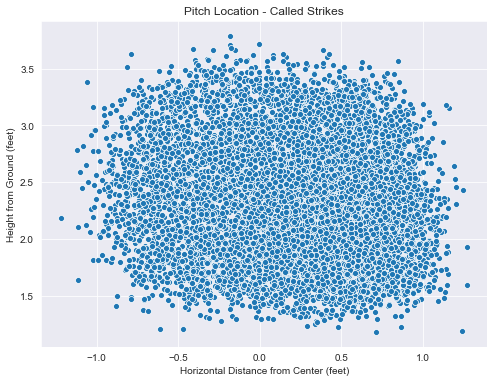

In [20]:
# Create called strike subset of pitch data.
calledstrikes = allpitches[allpitches['call'] == 'StrikeCalled']

# Plot called strike pitch location.
plt.subplots(figsize=(8,6))
sns.scatterplot(x=calledstrikes['plate_side'], y=calledstrikes['plate_height'])
plt.title('Pitch Location - Called Strikes')
plt.xlabel('Horizontal Distance from Center (feet)')
plt.ylabel('Height from Ground (feet)')
plt.show()

This is interesting. Called strikes are all showing in and around what I have chosen as a generic strike zone: one foot on either side of the center of the plate and a height ranging from 1.5 to 3.5 feet. This supports my theory that Trackman is misreading bounced pitches. I might be able to solidify that theory by examining pitches grouped by pitch call.

In [21]:
# Group data by pitch call, check height summary statistics.
pitch_call = allpitches.groupby('call')
pitch_call['plate_height'].agg(['mean', 'median', 
                          'min', 'max']).reset_index()

,call,mean,median,min,max
0,BallCalled,2.057427,1.828928,-2.150201,7.512057
1,FoulBall,2.490416,2.497806,0.347350,4.555476
2,HitByPitch,3.552273,3.629780,0.812674,5.113398
3,InPlay,2.347497,2.339836,0.229557,4.369109
4,StrikeCalled,2.334189,2.293967,1.181978,3.791743
5,StrikeSwinging,2.154109,2.087462,-0.350539,4.626515


All negative values were either swinging strikes or pitches that were called balls. This is consistent with the theory that these were pitches that hit the ground.

In [22]:
bounced = allpitches[allpitches['plate_height'] < 0]
bounced.describe()

,pitch_id,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle
count,375.000000,375.000000,365.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000
mean,24008.746667,84.646365,2344.164262,238.036145,5.933732,-2.129374,5.832621,0.109530,0.203984,-0.406721,1.415298,-10.423282,4.045268
std,13390.133887,4.416500,229.644276,77.497123,0.429525,0.754641,0.480818,0.501060,0.588844,0.355922,0.785081,1.025354,1.644496
min,204.000000,73.439192,1288.755924,0.054012,2.545909,-4.643329,4.564903,-1.309108,-1.747030,-2.150201,-1.003537,-14.244603,-1.072563
25%,12619.500000,81.644390,2213.031829,185.396825,5.719148,-2.537034,5.453808,-0.207390,0.016505,-0.596569,0.951112,-11.089396,3.174868
50%,24994.000000,83.675165,2354.576987,258.486324,5.993121,-2.131552,5.874958,0.018858,0.242860,-0.319611,1.384188,-10.542609,4.126097
75%,35046.500000,87.093434,2485.393673,298.695010,6.187705,-1.744077,6.195848,0.377675,0.526294,-0.134791,1.836122,-9.839291,5.087068
max,46194.000000,97.373769,3002.884411,357.098147,6.774236,-0.295258,6.904649,2.085883,1.851552,-0.000090,4.545302,-6.387980,9.981524


In [23]:
bounced.groupby('call').size()

call
BallCalled        355
StrikeSwinging     20
dtype: int64

There are 375 total pitches in the data set with negative height. A split between 355 balls and 20 swinging strikes seems consistent with bounced pitches. I will proceed with the assumption that this is correct, and that negative height values represent bounced pitches.

**Assumption: Pitches with negative height location values are misreadings of bounced pitches.** 

375 data points will not have a dramatic effect on a set of 46,000, but it still makes sense to replace these values with zeroes, as zero is the minimum possible lower bound for height. Interestingly, the horizontal location data look reasonable for this subset. I will not modify those.

In [25]:
# Replace negative height location values with zeroes.
allpitches.loc[allpitches.plate_height < 0, 'plate_height'] = 0

### Duplicates###

Next, I will check for duplicate data.

In [28]:
# Find and isolate duplicate rows.
pitch_dupes = allpitches.copy()
pitch_dupes['duplicate'] = pitch_dupes.duplicated()
pitch_dupes = pitch_dupes[pitch_dupes['duplicate'] == True]
pitch_dupes.head()

,pitch_id,p_type,call,result,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle,duplicate


There are no duplicate rows in this data set. Now, I will make certain there are no duplicate pitch IDs.

In [29]:
# Check for duplicate pitch IDs. Create a grouped version of the allpitches data 
# set, aggregated by pitch ID, sort so the largest total appears first.
pitching_grouped = allpitches.groupby('pitch_id')\
                            .size().reset_index(name='id_count')
pitching_grouped.sort_values('id_count', ascending=False).head()

,pitch_id,id_count
0,0,1
30861,30907,1
30863,30909,1
30864,30910,1
30865,30911,1


The maximum id count is 1, so there are no duplicate pitch IDs in the data set, either. 

### Dividing Data and Further Examination of Null Values ###

The next order of business is to split the data set into fastball and slider subsets. I will need to examine them separately, as fastballs and sliders have different characteristics defining them as "good". I would not be able to judge slider velocity adequately in a data set full of fastballs.

**Assumption: Fastballs and sliders must be judged independently because they have different defining quality characteristics.**

In [30]:
fastballs = allpitches[allpitches['p_type'] == 'FB']
sliders = allpitches[allpitches['p_type'] == 'SL']

fastballs.describe()

,pitch_id,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle
count,31690.000000,31690.000000,31685.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000
mean,23111.992521,91.868825,2189.129762,140.794058,5.875814,-2.164260,6.051894,1.068922,-0.868369,2.435314,0.081056,-5.668885,1.399980
std,13369.760542,2.633643,183.201861,22.136042,0.560723,0.827458,0.475398,0.421426,0.412568,0.817714,0.804577,1.106567,1.270790
min,0.000000,80.628393,461.149269,36.261187,2.271348,-5.276412,4.158872,-2.969474,-2.199608,0.000000,-3.161560,-10.224238,-3.335348
25%,11563.250000,90.200263,2066.861862,126.454867,5.638910,-2.698782,5.765650,0.844864,-1.183220,1.886565,-0.457041,-6.397669,0.584293
50%,23099.000000,91.878653,2191.756851,143.360623,5.935117,-2.120833,6.065151,1.148641,-0.879669,2.420202,0.102645,-5.647790,1.434492
75%,34639.750000,93.552089,2311.919092,156.412678,6.214448,-1.624239,6.381406,1.370376,-0.580205,2.959310,0.630098,-4.937680,2.269333
max,46361.000000,103.288490,3640.436613,344.777346,8.513335,0.304050,7.744261,5.385477,1.063228,7.512057,3.711012,4.243111,6.048673


In [31]:
sliders.describe()

,pitch_id,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle
count,14611.000000,14611.000000,14040.000000,14611.000000,14611.000000,14611.000000,14611.000000,14611.000000,14611.000000,14611.000000,14611.000000,14611.000000,14611.000000
mean,23320.270139,83.199333,2348.527418,243.835998,5.806219,-2.336765,5.711676,0.141348,0.476281,1.862890,0.553825,-7.990040,3.657238
std,13424.627509,3.716096,247.917274,52.045861,0.571868,0.799193,0.489416,0.388967,0.444997,0.872360,0.808661,1.316518,1.301883
min,4.000000,69.830884,704.081215,0.054012,2.383158,-5.333208,3.623688,-4.055594,-1.740427,0.000000,-3.826428,-14.244603,-1.246969
25%,11623.000000,80.612885,2205.973368,209.864709,5.573379,-2.816740,5.406141,-0.128959,0.179871,1.282517,0.029032,-8.863020,2.787564
50%,23352.000000,83.150744,2345.541585,249.190909,5.887520,-2.303808,5.718499,0.149483,0.381485,1.857165,0.572752,-7.975417,3.598720
75%,35079.500000,85.950392,2504.152451,281.335384,6.160000,-1.845666,6.065517,0.404286,0.685369,2.436669,1.083758,-7.122444,4.469136
max,46357.000000,94.385761,3726.136503,359.883393,7.286791,1.031696,7.468946,1.807982,4.259823,5.834345,4.545302,-2.139822,9.981524


Only 5 of the 576 null spin rate entries are fastballs. My grading methodology will depend on four major factors: velocity, spin rate, movement, and location. With the data complete for all elements but spin rate, I think it would be a mistake to remove the rows with null values from the data set. These pitches should still be assessable with the information available. Instead, I will replace the null values with the respective mean values for fastballs and sliders. I waited until this stage to make the adjustment because I assumed the means would be very different, and that is the case: for fastballs, it is 2,189 RPM, but for sliders, it is 2,349 RPM.

In [32]:
# Fill null spin rate values with the mean spin rate for each pitch type.
fastballs['spin'].fillna(fastballs['spin'].mean(), inplace=True)
sliders['spin'].fillna(sliders['spin'].mean(), inplace=True)

## Velocity##

I will start a further examination of velocity by plotting its distribution by pitch.

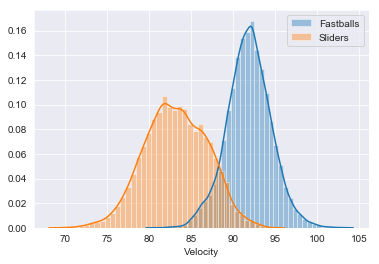

In [33]:
# Plot histograms for velocity by pitch type.
sns.distplot(fastballs['speed'], bins=40, label='Fastballs', axlabel='Velocity')
sns.distplot(sliders['speed'], bins=40, label='Sliders', axlabel='Velocity')
plt.legend()
plt.show()

Fastballs and sliders each show normal-looking distributions, so using standard deviations for the velocity component of the value formula should be valid.

## Spin Rate##

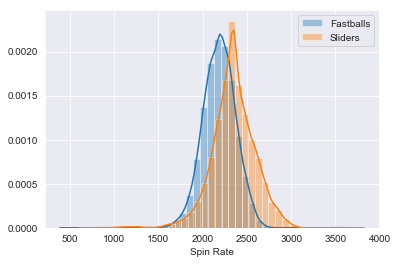

In [34]:
# Plot histograms for spin rate by pitch type.
sns.distplot(fastballs['spin'], bins=40, label='Fastballs', axlabel='Spin Rate')
sns.distplot(sliders['spin'], bins=40, label='Sliders', axlabel='Spin Rate')
plt.legend()
plt.show()

Spin rate also shows distributions that look close to normal, if a little tightly distributed around the mean. Standard deviation should be sufficient for the spin rate component of the model as well.

## Movement: Horizontal and Vertical Break##

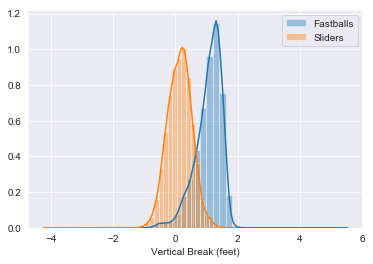

In [35]:
# Plot histograms for vertical break by pitch type.
sns.distplot(fastballs['vert_break'], bins=40, label='Fastballs', 
             axlabel='Vertical Break (feet)')
sns.distplot(sliders['vert_break'], bins=40, label='Sliders', 
             axlabel='Vertical Break (feet)')
plt.legend()
plt.show()

Again, there are distinct distributions between fastballs and sliders, with fastballs showing some left skew and more positive break. There are also few outliers, so I can examine those more closely.

In [36]:
# Examine vertical break outliers among fastballs.
fastballs[(fastballs.vert_break < -1.5) | (fastballs.vert_break > 2.5)]

,pitch_id,p_type,call,result,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle
26866,5431,FB,BallCalled,Undefined,90.564397,2295.275653,157.919403,6.392985,-2.023116,6.142601,5.385477,-2.185697,7.512057,-0.899450,4.243111,-1.539103
34822,14343,FB,BallCalled,Undefined,95.919716,2001.875640,140.576607,5.455482,-2.296044,5.778684,2.671045,-2.197613,4.089222,-2.115028,-1.350937,-2.437532
44679,28235,FB,StrikeCalled,Undefined,90.356775,2067.782480,344.777346,3.862251,-0.702426,6.409641,-2.969474,0.807430,2.335414,0.296744,-8.213046,2.023512


In [37]:
# Examine vertical break outliers among sliders.
sliders[(sliders.vert_break < -1.5) | (sliders.vert_break > 2)]

,pitch_id,p_type,call,result,speed,spin,axis,height,side,extension,vert_break,horz_break,plate_height,plate_side,vert_angle,horz_angle
7825,29683,SL,BallCalled,Undefined,87.155008,2372.754442,336.487245,3.138855,-0.406552,6.901879,-4.055594,1.763469,1.171495,-0.817553,-9.958391,1.572277
35805,15432,SL,StrikeSwinging,Undefined,79.769977,2666.948915,338.472360,5.591096,-0.799705,5.111672,-1.541284,0.606751,1.423457,-0.458980,-10.485406,1.069579


For vertical break, there are only three fastballs and two sliders that I would consider true outliers. These will not have any effect on calculations in data sets of these sizes, and will not change classification based on standard deviations, so I will ignore them.

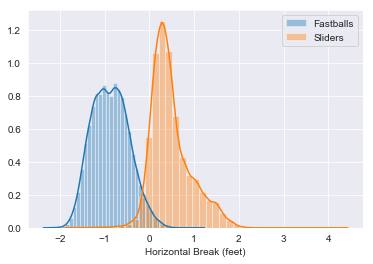

In [38]:
# Plot histograms for horizontal break by pitch type.
sns.distplot(fastballs['horz_break'], bins=40, label='Fastballs', 
             axlabel='Horizontal Break (feet)')
sns.distplot(sliders['horz_break'], bins=40, label='Sliders', 
             axlabel='Horizontal Break (feet)')
plt.legend()
plt.show()

Plotting fastballs and sliders separately helps clarify previous questions immensely. Prior to splitting the data, the majority of the data set showed negative movement, back toward the left-handed hitter. Now, we can see that almost all negative movement is associated with fastballs (and almost no positive movement). Sliders almost all move away from the left-handed hitter, which is what we would have expected. The negative effect was so pronounced because there are more than twice as many fastballs in the data set than sliders.

Both histograms are approaching normal, but the slider one has a more pronounced right skew (meaning there are more sliders than we would expect in a normal distribution with close to zero horizontal movement than sliders a lot of movement). I will do a quick examination of outliers here as well.

In [32]:
# Examine horizontal break outliers among fastballs (output suppressed).
fastballs[(fastballs.horz_break < -2) | (fastballs.horz_break > 1)]

In [34]:
# Examine horizontal break outliers among sliders (output suppressed).
sliders[(sliders.horz_break < -1) | (sliders.horz_break > 2.5)]

I see no cause for concern with horizontal break, either. With one exception, all outliers are just beyond the ranges specified. I see no problem moving forward with these data without modification. Now, I can calculate overall movement.

## Combined Movement##

I am adding a column to both data frames that will represent movement in a single component. I will do this by employing the Pythagorean theorem.

In [39]:
# Add single-component movement column using the Pythagorean theorem.
fastballs['movement'] = np.sqrt(
    (fastballs['vert_break']**2) + (fastballs['horz_break']**2))
sliders['movement'] = np.sqrt(
    (sliders['vert_break']**2) + (sliders['horz_break']**2))

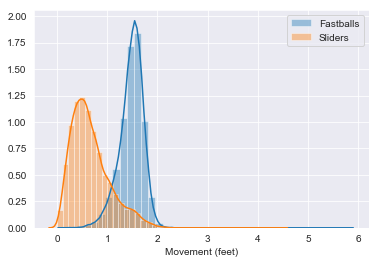

In [40]:
# Plot histograms for movement by pitch type.
sns.distplot(fastballs['movement'], bins=40, label='Fastballs', 
             axlabel='Movement (feet)')
sns.distplot(sliders['movement'], bins=40, label='Sliders', 
             axlabel='Movement (feet)')
plt.legend()
plt.show()

The overall movement histograms both show some skew (left skew for fastballs and right skew for sliders), but remain close enough to normal to use standard deviations for scoring in my model.

## Location: Definition and Scoring##

In [41]:
# Set table style to display properly.

In [42]:
%%html
<style>
table {float:left}
</style>

My definition of good location will be as follows. For sliders, I am adding 0.25 feet to the outside edge to account for sliders that are intentionally located just beyond the strike zone.

### Fastball Location

| Grade         | Location      |  Coordinates     |
| ------------- |---------------|------------------|
| 80            | Left or right edge, in strike zone |  (-1 $\leq$ x $\leq$ -0.5 or 0.5 $\leq$ x $\leq$ 1) and 1.5 $\leq$ y $\leq$ 3.5 |
| 70            |       -        |        -          |
| 60            | Top or bottom edge, center, in strike zone |  (1.5 $\leq$ y $\leq$ 2 or 3 $\leq$ y $\leq$ 3.5) and -0.5 $\leq$ x $\leq$ 0.5 |
| 50            |       -        |        -          |
| 40            | Center of strike zone |  -0.5 $\leq$ x $\leq$ 0.5 and 2 $\leq$ y $\leq$ 3 |
| 30            |       -        |        -          |
| 20            | Outside of strike zone |  x < -1, x > 1, y < 1.5, y > 3.5 |


### Slider Location

| Grade         | Location      |  Coordinates     |
| ------------- |---------------|------------------|
| 80            | Left or right edge, in strike zone |  (-1 $\leq$ x $\leq$ -0.5 or 0.5 $\leq$ x $\leq$ 1.25) and 1.5 $\leq$ y $\leq$ 3.5 |
| 70            |       -        |        -          |
| 60            | Top or bottom edge, center, in strike zone |  (1.5 $\leq$ y $\leq$ 2 or 3 $\leq$ y $\leq$ 3.5) and -0.5 $\leq$ x $\leq$ 0.5 |
| 50            |       -        |        -          |
| 40            | Center of strike zone |  -0.5 $\leq$ x $\leq$ 0.5 and 2 $\leq$ y $\leq$ 3 |
| 30            |       -        |        -          |
| 20            | Outside of strike zone |  x < -1, x > 1.25, y < 1.5, y > 3.5 |

In [43]:
def fb_loc(df):
    '''Function to score fastball location, based on previously
    determined location quality parameters.
    '''

    if (df['plate_side'] < -1):
        return 20
    elif (df['plate_side'] > 1):
        return 20
    elif (df['plate_height'] < 1.5):
        return 20
    elif (df['plate_height'] > 3.5):
        return 20
    elif (df['plate_side'] > -0.5) and (df['plate_side'] < 0.5)\
        and (df['plate_height'] > 2) and (df['plate_height'] < 3):
        return 40
    elif (df['plate_side'] > -0.5) and (df['plate_side'] < 0.5)\
        and (df['plate_height'] >= 1.5) and (df['plate_height'] <= 2):
        return 60
    elif (df['plate_side'] > -0.5) and (df['plate_side'] < 0.5)\
        and (df['plate_height'] >= 3) and (df['plate_height'] <= 3.5):
        return 60
    else:
        return 80

# Score fastballs.
fastballs['location_score'] = fastballs.apply(fb_loc, axis = 1)

In [44]:
def sl_loc(df):
    '''Function to score slider location, based on previously
    determined location quality parameters.
    '''

    if (df['plate_side'] < -1):
        return 20
    elif (df['plate_side'] > 1.25):
        return 20
    elif (df['plate_height'] < 1.5):
        return 20
    elif (df['plate_height'] > 3.5):
        return 20
    elif (df['plate_side'] > -0.5) and (df['plate_side'] < 0.5)\
        and (df['plate_height'] > 2) and (df['plate_height'] < 3):
        return 40
    elif (df['plate_side'] > -0.5) and (df['plate_side'] < 0.5)\
        and (df['plate_height'] >= 1.5) and (df['plate_height'] <= 2):
        return 60
    elif (df['plate_side'] > -0.5) and (df['plate_side'] < 0.5)\
        and (df['plate_height'] >= 3) and (df['plate_height'] <= 3.5):
        return 60
    else:
        return 80

# Score sliders.
sliders['location_score'] = sliders.apply(sl_loc, axis = 1)

## Velocity Scoring###

In [45]:
# Extract velocity mean and standard deviation.
fb_velo_mn = fastballs['speed'].mean()
fb_velo_sd = fastballs['speed'].std()
sl_velo_mn = sliders['speed'].mean()
sl_velo_sd = sliders['speed'].std()

# Calculate number of standard deviations from the mean for each pitch.
fastballs['velo_score'] = (fastballs['speed'] - fb_velo_mn)/fb_velo_sd
sliders['velo_score'] = (sliders['speed'] - sl_velo_mn)/sl_velo_sd

For purposes of this model, I will cap standard deviations at 3. I will adjust any values greater than 3 or less than -3 to 3 and -3, respectively. This will remove any minimal effects of outliers on the model, preventing any one extreme outlier from overly influencing an individual score. It will also and enable calculations to mirror with scout scoring styles. 

In [46]:
# Adjust values of more than three standard deviations from the mean to 3.
fastballs.loc[fastballs.velo_score > 3, 'velo_score'] = 3
fastballs.loc[fastballs.velo_score < -3, 'velo_score'] = -3
sliders.loc[sliders.velo_score > 3, 'velo_score'] = 3
sliders.loc[sliders.velo_score < -3, 'velo_score'] = -3

## Movement Scoring###

In [47]:
# Extract velocity mean and standard deviation.
fb_move_mn = fastballs['movement'].mean()
fb_move_sd = fastballs['movement'].std()
sl_move_mn = sliders['movement'].mean()
sl_move_sd = sliders['movement'].std()

# Calculate number of standard deviations from the mean for each pitch.
fastballs['move_score'] = (fastballs['movement'] - fb_move_mn)/fb_move_sd
sliders['move_score'] = (sliders['movement'] - sl_move_mn)/sl_move_sd

# Adjust values of more than three standard deviations from the mean to 3.
fastballs.loc[fastballs.move_score > 3, 'move_score'] = 3
fastballs.loc[fastballs.move_score < - 3, 'move_score'] = -3
sliders.loc[sliders.move_score > 3, 'move_score'] = 3
sliders.loc[sliders.move_score < - 3, 'move_score'] = -3

## Spin Rate Scoring##

In [49]:
# Extract velocity mean and standard deviation.
fb_spin_mn = fastballs['spin'].mean()
fb_spin_sd = fastballs['spin'].std()
sl_spin_mn = sliders['spin'].mean()
sl_spin_sd = sliders['spin'].std()

# Calculate number of standard deviations from the mean for each pitch.
fastballs['spin_score'] = (fastballs['spin'] - fb_spin_mn)/fb_spin_sd
sliders['spin_score'] = (sliders['spin'] - sl_spin_mn)/sl_spin_sd

# Adjust values of more than three standard deviations from the mean to 3.
fastballs.loc[fastballs.spin_score > 3, 'spin_score'] = 3
fastballs.loc[fastballs.spin_score < - 3, 'spin_score'] = -3
sliders.loc[sliders.spin_score > 3, 'spin_score'] = 3
sliders.loc[sliders.spin_score < - 3, 'spin_score'] = -3

In [50]:
# Convert scores to scouting score equivalents.

scores = ['velo_score', 'move_score', 'spin_score']

for score in scores:
    fastballs[score] = (10*fastballs[score]) + 50
    sliders[score] = (10*sliders[score]) + 50

## Final Model##

I now have equivalent scales for the four score inputs into the model. The model itself is:

$Pitch Quality = 0.25 \cdot Location Score + 0.25 \cdot Velocity Score + 0.25 \cdot Movement Score + 0.25 \cdot Spin Score$

In [51]:
# Build simplified results data frames.
fastballs_results = fastballs[['call', 'result', 'location_score', 'velo_score', 
                               'move_score', 'spin_score']].copy()
sliders_results = sliders[['call', 'result', 'location_score', 'velo_score', 
                           'move_score', 'spin_score']].copy()

# Calculate results based on the model.
fastballs_results['grade'] = (0.25*fastballs_results['location_score'])\
    + (0.25*fastballs_results['velo_score'])\
    + (0.25*fastballs_results['move_score'])\
    + (0.25*fastballs_results['spin_score'])
sliders_results['grade'] = (0.25*sliders_results['location_score'])\
    + (0.25*sliders_results['velo_score'])\
    + (0.25*sliders_results['move_score'])\
    + (0.25*sliders_results['spin_score'])

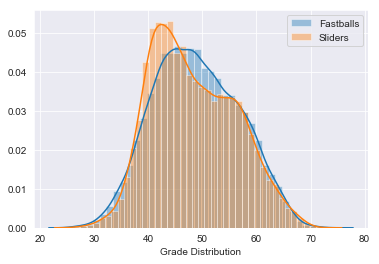

In [52]:
# Examine histgrams of the grades.
sns.distplot(fastballs_results['grade'], bins=40, label='Fastballs', 
             axlabel='Grade Distribution')
sns.distplot(sliders_results['grade'], bins=40, label='Sliders', 
             axlabel='Grade Distribution')
plt.legend()
plt.show()

Both distributions show some right skew and not entirely normal. The slider histogram looks almost bimodal, with what almost looks like a secondary peak in the 55 range. This is likely a function of the discrete nature of the location scores. If location score were a continuous variable, I would expect these to look more normal.


## Model Evaluation##


In order to assess the performance of the model, I now must consider pitch outcomes. There are many ways to do this, and all require additional assumptions. I could score each outcome event differently, but that would be a mostly subjective endeavor. Is a swinging strike worth more than a called strike? It might be, but I cannot say for certain. I am choosing to classify events in three ways: positive, negative, and neutral. I am taking the basis of this idea from the the inputs that go into calculating fielding-independent pitching (FIP), originally developed by Voros McCracken. 

- For these purposes, I can say definitively that a swinging strike and a called strike are positive outcomes. 
- I can also say definitively that a called ball and a hit by pitch are negative outcomes. 
- "In play" is a more difficult event to judge. Almost all in play events are situation and fielding dependent. It can be positive (an out) and it can be negative (a hit). I am assuming that factors other than the quality of the pitch will mostly outweigh the attributes of the pitch itself, so I am labeling all "in play" events as neutral, with one exception: home runs. 
- While the home run depends on the batter's performance, it is mostly independent of the other external factors, and I feel comfortable labeling these as negative outcomes. 
- The trickiest result is the foul ball. A foul ball can be positive or negative, depending on the scenario. If there are fewer than two strikes, it is a positive event for a pitcher. If there are two strikes, it becomes more of a negative event. I have no choice here but to label foul balls neutral, as I have no additional information about the situation surrounding each pitch. 

**Assumption: Strikes are positive events, balls, hit-by-pitch, and home runs are negative events, and "in play" and foul balls are neutral events.**

Now, I will use these definitions to classify all outcomes.

In [53]:
def outcome(df):
    '''Function to classify outcomes as positive, negative, 
    or neutral.
    '''

    if (df['result'] == 'HomeRun'):
        return 'Negative'
    elif (df['call'] == 'BallCalled'):
        return 'Negative'
    elif (df['call'] == 'HitByPitch'):
        return 'Negative'
    elif (df['call'] == 'InPlay'):
        return 'Neutral'
    elif (df['call'] == 'FoulBall'):
        return 'Neutral'
    else:
        return 'Positive'
    
# Classify outcomes.
fastballs_results['outcome'] = fastballs_results.apply(outcome, axis = 1)
sliders_results['outcome'] = sliders_results.apply(outcome, axis = 1)

From the histograms, it appeared as though there were very few (if any) pitches that scored above 70 in my model. I will examine that more closely.

In [54]:
# Count pitches scoring above 70.
print("70+ fastballs:", 
      fastballs_results['grade'][fastballs_results['grade'] >= 70].count())
print("70+ sliders:", 
      sliders_results['grade'][sliders_results['grade'] >= 70].count())

70+ fastballs: 30
70+ sliders: 7


As I assess my model, I want to look at the performance in different tiers of scores. There are so few 70+ pitches that I will include them with the 60+ tier as I classify pitches.

In [55]:
def tiers(df):
    '''Function to classify scoring into tiers. 
    '''

    if (df.grade >= 60):
        return 60
    elif (df.grade >= 50) & (df.grade < 60):
        return 50
    elif (df.grade >= 40) & (df.grade < 50):
        return 40
    elif (df.grade >= 30) & (df.grade < 40):
        return 30
    else:
        return 20
    
# Classify tiers.
fastballs_results['tier'] = fastballs_results.apply(tiers, axis = 1)
sliders_results['tier'] = sliders_results.apply(tiers, axis = 1)

### Results###

I want to evaluate how the various graded tiers of pitches performed. I will look specifically at how the model performed related to positive pitch outcomes. First, I want to get an idea of how many positives there are total.

In [56]:
# Group fastballs by outcome.
fastballs_results.groupby(fastballs_results['outcome']).size()

outcome
Negative    10969
Neutral     11534
Positive     9187
dtype: int64

In [57]:
# Group sliders by outcome.
sliders_results.groupby(sliders_results['outcome']).size()

outcome
Negative    5565
Neutral     4277
Positive    4769
dtype: int64

### Fastball Results: Positive Outcomes###

To evaluate performance, I will check the quantity of positive outcomes in each tier against the total outcomes in that tier. This will allow for direct comparison of the tiers. If I were to examine the percentage of positives to total positives, that would depend on the size of the sample in each tier and provide misleading results. First, I will look at the raw numbers.

In [58]:
fastballs_results.describe()

,location_score,velo_score,move_score,spin_score,grade,tier
count,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000
mean,45.474913,49.994553,50.035483,50.000475,48.876356,43.865888
std,24.284973,9.942768,9.776141,9.906845,7.887535,8.365582
min,20.000000,20.000000,20.000000,20.000000,24.804685,20.000000
25%,20.000000,43.664433,44.561311,43.326930,42.984735,40.000000
50%,40.000000,50.037315,51.238824,50.141951,48.481891,40.000000
75%,80.000000,56.391390,56.705727,56.701662,54.735421,50.000000
max,80.000000,80.000000,80.000000,80.000000,74.727027,60.000000


In [59]:
fastballs_results.groupby(['tier', 'outcome']).size()

tier  outcome 
20    Negative      75
      Neutral       18
      Positive       7
30    Negative    2707
      Neutral      850
      Positive     578
40    Negative    6119
      Neutral     4510
      Positive    3136
50    Negative    1634
      Neutral     4936
      Positive    4224
60    Negative     434
      Neutral     1220
      Positive    1242
dtype: int64

The mean grade is 48.9, which is close to the scouting scoring conventions (50). A quick examination of this output shows that the majority of positive outcomes are above 50 and the overwhelming majority of negative outcomes are below 50. I will explore this with a bit more scrutiny.

In [60]:
# Calculate the overall percentage of positive fastball outcomes.
print('Fastball Positive Outcome Percentage:', '%.1f' %
      ((100*fastballs_results['outcome'][fastballs_results['outcome'] 
        == 'Positive'].count())/(fastballs_results['outcome'].count())),'%')

Fastball Positive Outcome Percentage: 29.0 %


In [61]:
# Divide fastball results into tiers, calculate positive fastball outcome percentages.
fb60 = fastballs_results[fastballs_results.grade >= 60]
fb50 = fastballs_results[(fastballs_results.grade >= 50) & (
    fastballs_results.grade < 60)]
fb40 = fastballs_results[(fastballs_results.grade >= 40) & (
    fastballs_results.grade < 50)]
fb30 = fastballs_results[(fastballs_results.grade >= 30) & (
    fastballs_results.grade < 40)]
fb20 = fastballs_results[(fastballs_results.grade < 30)]

print('% Positive Outcomes - 60 Tier, Fastball:', 
      '%.1f' % (100*fb60['outcome'][
          fb60['outcome'] == 'Positive'].count()/fb60['outcome'].count()),'%')
print('% Positive Outcomes - 50 Tier, Fastball:', 
      '%.1f' % (100*fb50['outcome'][
          fb50['outcome'] == 'Positive'].count()/fb50['outcome'].count()),'%')
print('% Positive Outcomes - 40 Tier, Fastball:', 
      '%.1f' % (100*fb40['outcome'][
          fb40['outcome'] == 'Positive'].count()/fb40['outcome'].count()),'%')
print('% Positive Outcomes - 30 Tier, Fastball:', 
      '%.1f' % (100*fb30['outcome'][
          fb30['outcome'] == 'Positive'].count()/fb30['outcome'].count()),'%')
print('% Positive Outcomes - 20 Tier, Fastball:', 
      '%.1f' % (100*fb20['outcome'][
          fb20['outcome'] == 'Positive'].count()/fb20['outcome'].count()),'%')


% Positive Outcomes - 60 Tier, Fastball: 42.9 %
% Positive Outcomes - 50 Tier, Fastball: 39.1 %
% Positive Outcomes - 40 Tier, Fastball: 22.8 %
% Positive Outcomes - 30 Tier, Fastball: 14.0 %
% Positive Outcomes - 20 Tier, Fastball: 7.0 %


The model appears to have performed well. For the whole data set, 29% of the outcomes were positive. In the model, the above average-tiers (60 and 50) returned 42.9% and 39.1%, respectively. Only 7% of the outcomes in the lowest tier were positive outcomes. 



### Slider Results: Positive Outcomes###


Now, let's examine the same metrics for sliders.

In [62]:
sliders_results.describe()

,location_score,velo_score,move_score,spin_score,grade,tier
count,14611.000000,14611.000000,14611.000000,14611.000000,14611.000000,14611.000000
mean,43.387858,50.002974,49.969154,50.080271,48.360064,43.421395
std,25.088346,9.990485,9.871901,9.661051,7.791017,8.192017
min,20.000000,20.000000,32.811065,20.000000,26.346264,20.000000
25%,20.000000,43.039878,42.685157,44.446612,42.181930,40.000000
50%,40.000000,49.869249,47.995320,50.000000,47.277217,40.000000
75%,80.000000,57.403091,55.184079,56.041306,54.364463,50.000000
max,80.000000,80.000000,80.000000,80.000000,72.157244,60.000000


In [63]:
sliders_results.groupby(['tier', 'outcome']).size()

tier  outcome 
20    Negative      22
      Neutral        3
      Positive       5
30    Negative    1270
      Neutral      247
      Positive     450
40    Negative    3149
      Neutral     1707
      Positive    1933
50    Negative     895
      Neutral     1827
      Positive    1902
60    Negative     229
      Neutral      493
      Positive     479
dtype: int64

In [64]:
# Calculate the overall percentage of positive slider outcomes.
print('Slider Positive Outcome Percentage:', '%.1f' %
      ((100*sliders_results['outcome'][sliders_results['outcome'] 
        == 'Positive'].count())/(sliders_results['outcome'].count())),'%')

Slider Positive Outcome Percentage: 32.6 %


In [65]:
# Divide slider results into tiers, calculate positive slider outcome percentages.
sl60 = sliders_results[sliders_results.grade >= 60]
sl50 = sliders_results[(sliders_results.grade >= 50) & (sliders_results.grade < 60)]
sl40 = sliders_results[(sliders_results.grade >= 40) & (sliders_results.grade < 50)]
sl30 = sliders_results[(sliders_results.grade >= 30) & (sliders_results.grade < 40)]
sl20 = sliders_results[(sliders_results.grade < 30)]

print('% Positive Outcomes - 60 Tier, Slider:', 
      '%.1f' % (100*sl60['outcome'][
          sl60['outcome'] == 'Positive'].count()/sl60['outcome'].count()),'%')
print('% Positive Outcomes - 50 Tier, Slider:', 
      '%.1f' % (100*sl50['outcome'][
          sl50['outcome'] == 'Positive'].count()/sl50['outcome'].count()),'%')
print('% Positive Outcomes - 40 Tier, Slider:', 
      '%.1f' % (100*sl40['outcome'][
          sl40['outcome'] == 'Positive'].count()/sl40['outcome'].count()),'%')
print('% Positive Outcomes - 30 Tier, Slider:', 
      '%.1f' % (100*sl30['outcome'][
          sl30['outcome'] == 'Positive'].count()/sl30['outcome'].count()),'%')
print('% Positive Outcomes - 20 Tier, Slider:', 
      '%.1f' % (100*sl20['outcome'][
          sl20['outcome'] == 'Positive'].count()/sl20['outcome'].count()),'%')


% Positive Outcomes - 60 Tier, Slider: 39.9 %
% Positive Outcomes - 50 Tier, Slider: 41.1 %
% Positive Outcomes - 40 Tier, Slider: 28.5 %
% Positive Outcomes - 30 Tier, Slider: 22.9 %
% Positive Outcomes - 20 Tier, Slider: 16.7 %


The model performance for sliders was not quite as good as it was for fastballs, but it still shows a positive overall predictive capacity. The overall percentage of positive outcomes in the slider set was 32.6%. The top two tiers outperform this mark by a substantial margin, though the 50 tier was a bit better than the 60 tier. The percentage of positives declines steadily for all tiers below 50. These are still encouraging results, and I want to see how the model performed with negative outcomes.

### Fastball Results: Negative Outcomes###

I will repeat my methodology from above with negative outcomes.

In [66]:
# Calculate the overall percentage of negative fastball outcomes.
print('Fastball Negative Outcome Percentage:', '%.1f' %
      ((100*fastballs_results['outcome'][fastballs_results['outcome'] 
        == 'Negative'].count())/(fastballs_results['outcome'].count())),'%')

Fastball Negative Outcome Percentage: 34.6 %


In [67]:
# Calculate negative fastball outcome percentages.

print('% Positive Outcomes - 60 Tier, Fastball:', 
      '%.1f' % (100*fb60['outcome'][
          fb60['outcome'] == 'Negative'].count()/fb60['outcome'].count()),'%')
print('% Positive Outcomes - 50 Tier, Fastball:', 
      '%.1f' % (100*fb50['outcome'][
          fb50['outcome'] == 'Negative'].count()/fb50['outcome'].count()),'%')
print('% Positive Outcomes - 40 Tier, Fastball:', 
      '%.1f' % (100*fb40['outcome'][
          fb40['outcome'] == 'Negative'].count()/fb40['outcome'].count()),'%')
print('% Positive Outcomes - 30 Tier, Fastball:', 
      '%.1f' % (100*fb30['outcome'][
          fb30['outcome'] == 'Negative'].count()/fb30['outcome'].count()),'%')
print('% Positive Outcomes - 20 Tier, Fastball:', 
      '%.1f' % (100*fb20['outcome'][
          fb20['outcome'] == 'Negative'].count()/fb20['outcome'].count()),'%')


% Positive Outcomes - 60 Tier, Fastball: 15.0 %
% Positive Outcomes - 50 Tier, Fastball: 15.1 %
% Positive Outcomes - 40 Tier, Fastball: 44.5 %
% Positive Outcomes - 30 Tier, Fastball: 65.5 %
% Positive Outcomes - 20 Tier, Fastball: 75.0 %


The model performed very well for negative outcomes: 75% of the fastballs in the 20 tier and 65.5% in the 30 tier were graded as negative, versus 34.6% negatives in the full data set.

### Slider Results: Negative Outcomes###


In [68]:
# Calculate the overall percentage of negative slider outcomes.
print('Slider Negative Outcome Percentage:', '%.1f' %
      ((100*sliders_results['outcome'][sliders_results['outcome'] 
        == 'Negative'].count())/(sliders_results['outcome'].count())),'%')

Slider Negative Outcome Percentage: 38.1 %


In [69]:
# Calculate negative slider outcome percentages.

print('% Positive Outcomes - 60 Tier, Slider:', 
      '%.1f' % (100*sl60['outcome'][
          sl60['outcome'] == 'Negative'].count()/sl60['outcome'].count()),'%')
print('% Positive Outcomes - 50 Tier, Slider:', 
      '%.1f' % (100*sl50['outcome'][
          sl50['outcome'] == 'Negative'].count()/sl50['outcome'].count()),'%')
print('% Positive Outcomes - 40 Tier, Slider:', 
      '%.1f' % (100*sl40['outcome'][
          sl40['outcome'] == 'Negative'].count()/sl40['outcome'].count()),'%')
print('% Positive Outcomes - 30 Tier, Slider:', 
      '%.1f' % (100*sl30['outcome'][
          sl30['outcome'] == 'Negative'].count()/sl30['outcome'].count()),'%')
print('% Positive Outcomes - 20 Tier, Slider:', 
      '%.1f' % (100*sl20['outcome'][
          sl20['outcome'] == 'Negative'].count()/sl20['outcome'].count()),'%')


% Positive Outcomes - 60 Tier, Slider: 19.1 %
% Positive Outcomes - 50 Tier, Slider: 19.4 %
% Positive Outcomes - 40 Tier, Slider: 46.4 %
% Positive Outcomes - 30 Tier, Slider: 64.6 %
% Positive Outcomes - 20 Tier, Slider: 73.3 %


The model performed exceptionally well in judging negative outcomes for sliders as well: 73.3% of pitches in the 20 tier and 64.6% of pitches in the 30 tier were graded as negative, versus 38.1% negatives in the full data set.

## Conclusions and Next Steps##

I am satisfied with the performance of this initial model, especially considering it was built fully independent of outcomes, and with some major assumptions. It is a linear model with weights assumed to be equal for four major inputs, and it showed strong predictive capacity for positive outcomes and very strong predictive capacity for negative outcomes. If nothing else, the model validated some assumptions associated with conventional baseball wisdom. 

If I were to refine the model, I would want to have some additional information: first, I would want to work with situational data (mainly the pitch count) so that I could adequately judge whether a foul ball was a positive or negative event. 

In building a new model, I think that performance would improve notably if I incorporated the results. Fitting the existing model to the data would allow me to refine the input weights beyond the initial guesses. I suspect a good multivariate regression model might predict outcomes better, and machine learning classifiers should also perform well. I would expect different machine learning classifiers to zero in on more specific weighting of inputs in determining what makes good and bad pitches.

In any further work, I would validate the strike zone I used to make sure it was optimal, and refine it, if necessary.

I would also do some additional work in refining location grading, to make certain that my definition was as good as it could be.